## Import relevant librarires

In [1]:
import seaborn as sns
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

## Read in the merged dataset

In [2]:
stats = pd.read_csv("past_season_stats.csv")

### More data cleaning

In [3]:
stats.drop(columns=['L','MIN','W_15','L_15', 'W', 'WIN%_Post'], inplace=True)

In [4]:
stats.rename(columns={'OFFRTG': 'OFFRTG_15', 'DEFRTG': 'DEFRTG_15', 'NETRTG': 'NETRTG_15'}, inplace=True)

In [5]:
stats.to_csv("stats.csv", index=False)

## EDA

In [6]:
stats.describe()

,GP,WIN%,EFG%,FTA RATE,TOV%,OREB%,OPP EFG%,OPP FTA RATE,OPP TOV%,OPP OREB%,GP_15,WIN%_15,OFFRTG_15,DEFRTG_15,NETRTG_15,W_Post
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,52.644444,0.500141,0.511900,0.266648,0.147407,0.280241,0.511919,0.266793,0.147470,0.280589,15.822222,0.500533,108.339630,108.353704,-0.015185,13.485185
std,6.471518,0.154767,0.024999,0.030688,0.012152,0.027529,0.021624,0.028646,0.013313,0.021301,1.251715,0.192412,5.296996,4.653428,5.724086,5.533756
min,32.000000,0.151000,0.455000,0.188000,0.111000,0.215000,0.447000,0.204000,0.116000,0.228000,11.000000,0.000000,93.500000,96.500000,-15.800000,1.000000
25%,52.000000,0.389000,0.495000,0.246000,0.139000,0.262000,0.498000,0.246250,0.137250,0.267000,15.000000,0.375000,104.500000,105.100000,-3.775000,9.000000
50%,54.000000,0.500000,0.512000,0.264000,0.147000,0.279500,0.512000,0.267000,0.148000,0.280000,16.000000,0.500000,108.200000,108.350000,-0.200000,13.000000
75%,57.000000,0.610000,0.529750,0.287000,0.155750,0.297000,0.528000,0.285000,0.156000,0.295000,17.000000,0.625000,112.175000,111.450000,4.075000,17.000000
max,61.000000,0.923000,0.588000,0.397000,0.193000,0.359000,0.568000,0.360000,0.183000,0.341000,19.000000,0.933000,122.400000,121.100000,14.000000,30.000000


#### Pearson correlation tests

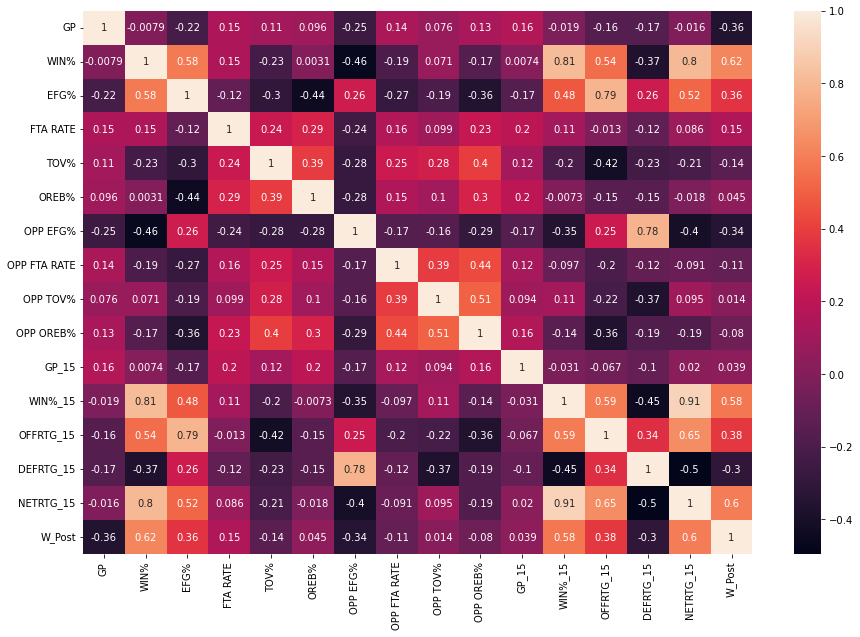

In [7]:
corr = stats.corr(method='pearson')

plt.rcParams["figure.figsize"] = (15,10)
sns.heatmap(corr, annot=True)
plt.show()

#### Pairplots of variables vs. outcome

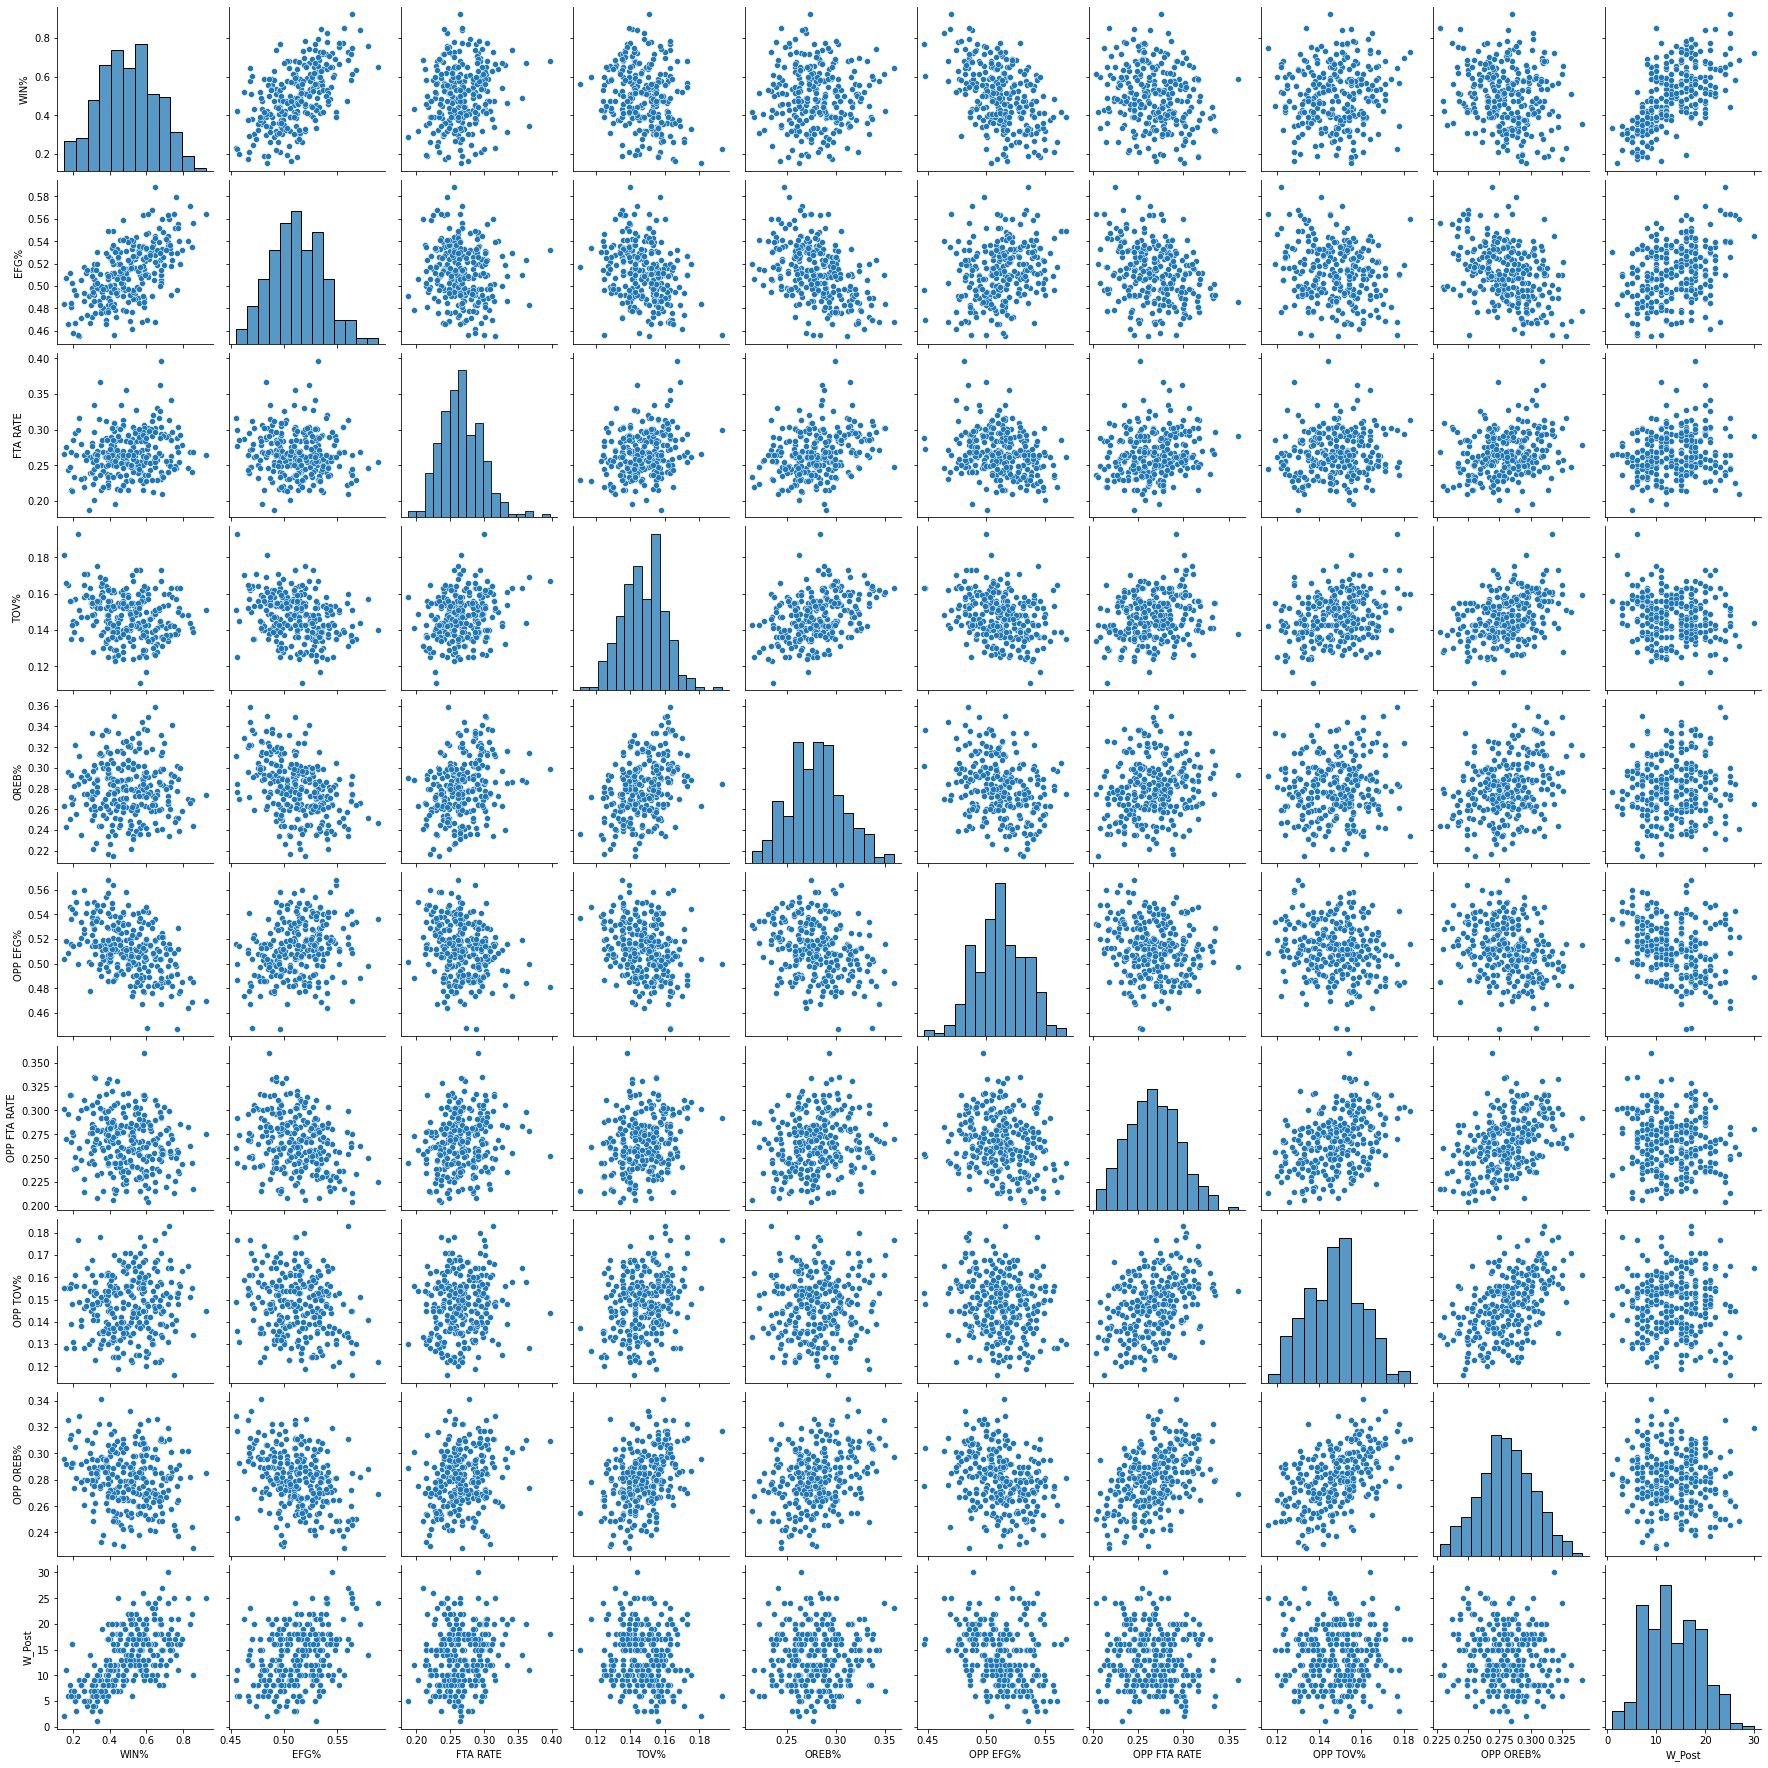

In [8]:
sns.pairplot(
    stats,
    x_vars=['WIN%','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%','W_Post'],
    y_vars=['WIN%','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%','W_Post'],
    palette = "husl", 
    kind = 'scatter'
)
plt.show()

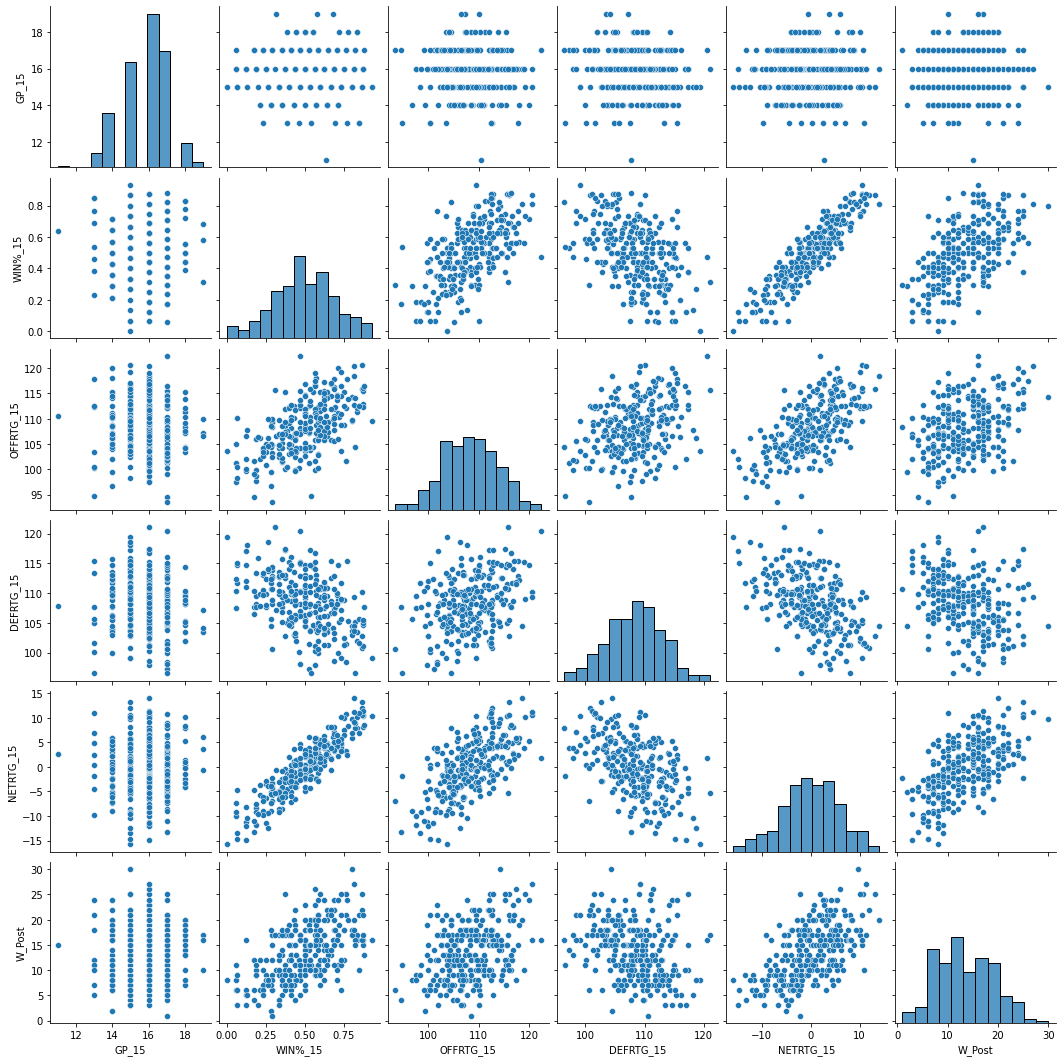

In [9]:
sns.pairplot(
    stats,
    x_vars=['GP_15','WIN%_15','OFFRTG_15','DEFRTG_15','NETRTG_15','W_Post'],
    y_vars=['GP_15','WIN%_15','OFFRTG_15','DEFRTG_15','NETRTG_15','W_Post'],
    palette = "husl", 
    kind = 'scatter'
)
plt.show()

## Partial Least Squares (PLS) Regression modeling

#### Declare predictor and outcome variables

In [10]:
X = stats.drop(columns=['Season','Team','W_Post'], axis=1)
y = stats['W_Post'].values

In [11]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [12]:
def plot_metrics(vals, ylabel, objective, xticks):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()
    return(xticks[idx])

In [13]:
def PLS(X,y):

    r2s = []
    mses = []
    rpds = []
    xticks = np.arange(1, len(list(X.columns))-1)
    for n_comp in xticks:
        y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd)

    
    optimal = plot_metrics(mses, 'MSE', 'min', xticks)
    
    optimal = plot_metrics(rpds, 'RPD', 'max', xticks)
    
    optimal = plot_metrics(r2s, 'R2', 'max', xticks)
    
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, optimal)
    
    print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
    
    plt.figure(figsize=(6, 6))
    with plt.style.context('ggplot'):
        plt.scatter(y, y_cv, color='blue')
        plt.plot(y, y, '-g', label='Expected regression line')
        z = np.polyfit(y, y_cv, 1)
        plt.plot(np.polyval(z, y), y, color='red', label='Predicted regression line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.plot()
    plt.show()

## Model Evaluation

#### Test out PLS model with all 9 seasons included

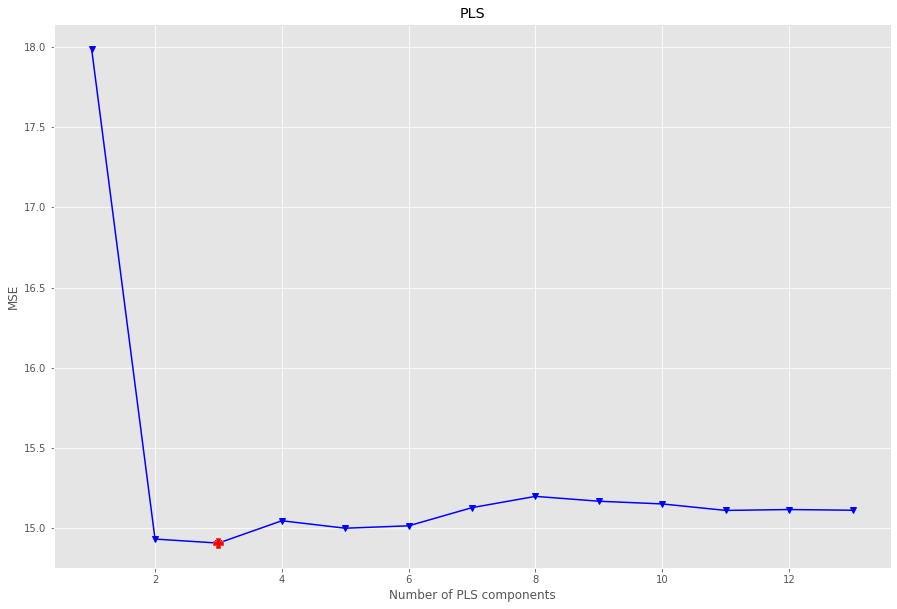

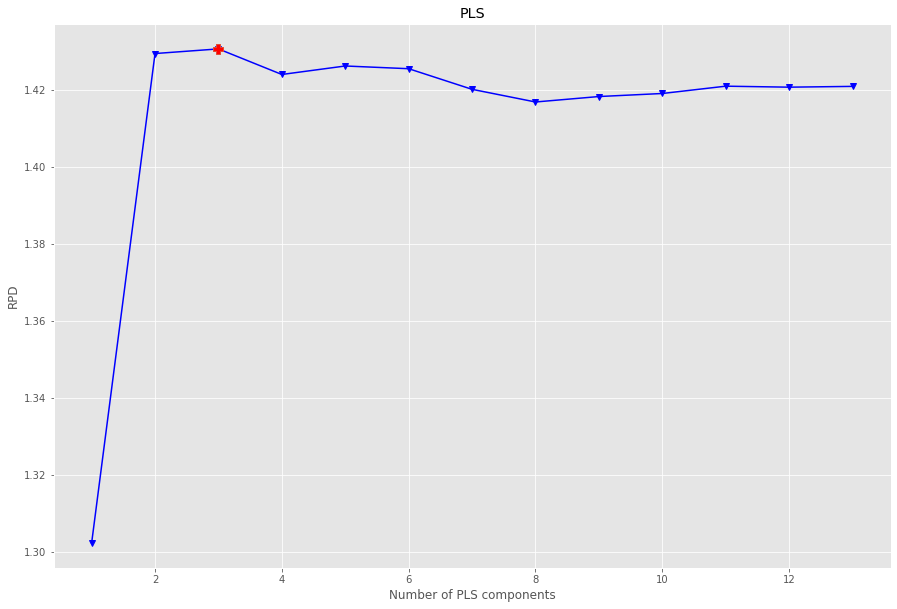

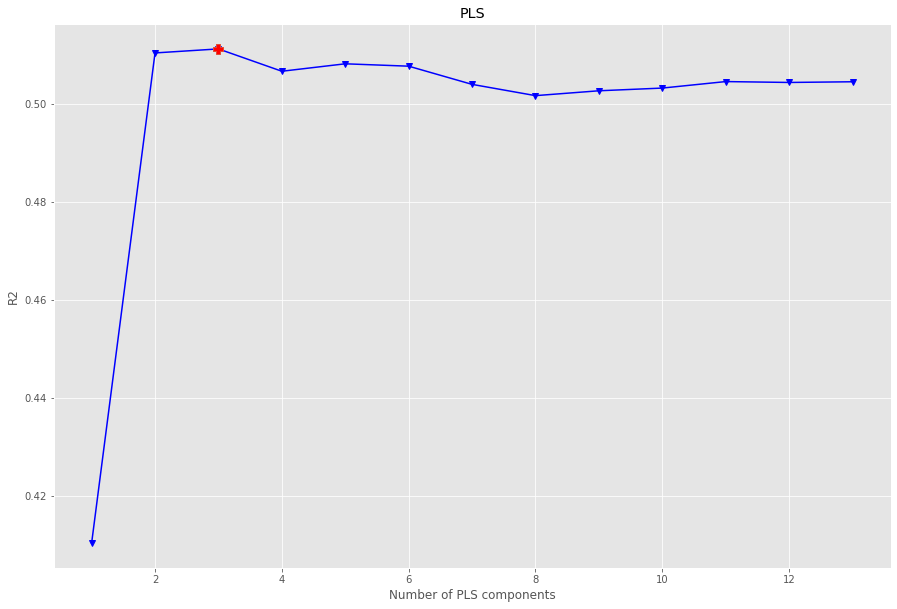

R2: 0.5113, MSE: 14.9085, RPD: 1.4305


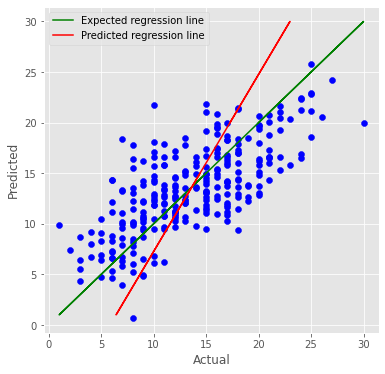

In [14]:
PLS(X,y)

### Test out model excluding the 2019-2020 and 2020-2021 seasons (Covid + Adjusted schedule seasons)

In [15]:
exclude_19_20 = stats[stats["Season"] != "2019-20"]
exclude_19_20 = exclude_19_20[exclude_19_20["Season"] != "2020-21"]

#### Declare new X, y based on filtered season dataset

In [16]:
X = exclude_19_20.drop(columns=['Season','Team','W_Post'], axis=1)
y = exclude_19_20['W_Post']

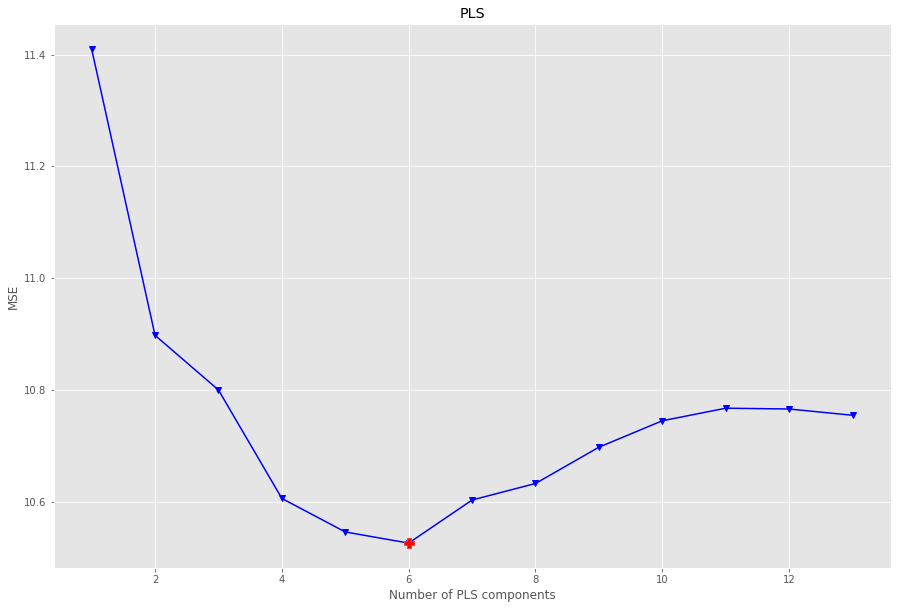

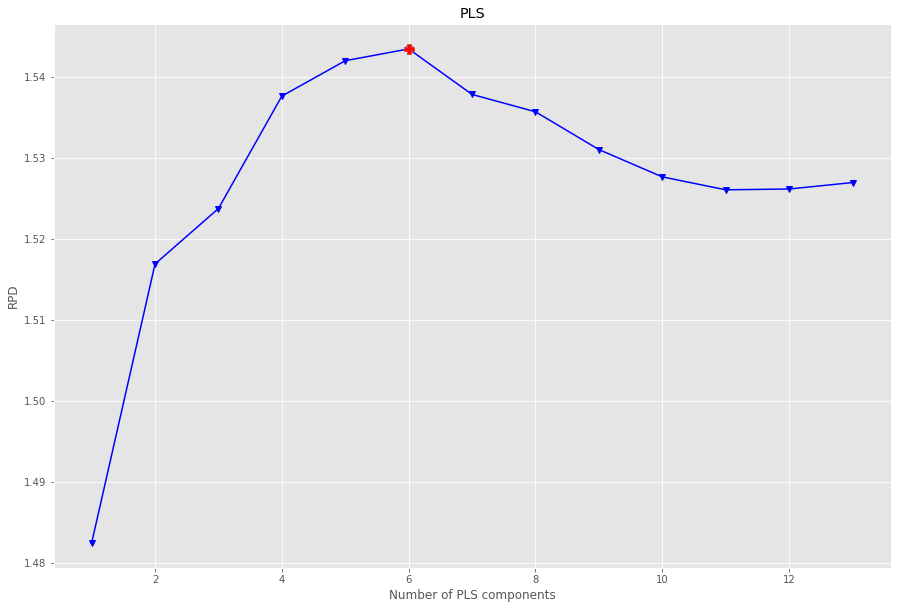

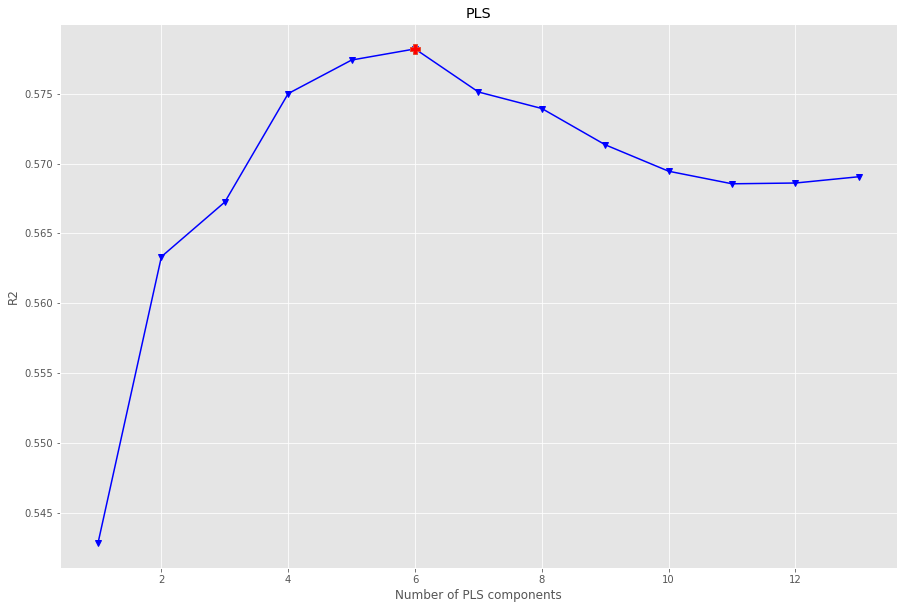

R2: 0.5782, MSE: 10.5266, RPD: 1.5434


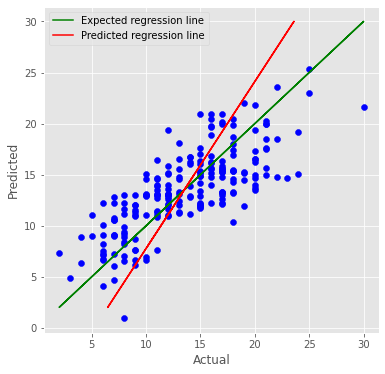

In [17]:
PLS(X,y)

## Predicting wins for the remainder of current NBA season: 2021-2022

In [18]:
curr_season = pd.read_csv("curr_season_stats.csv")

In [19]:
curr_season.head()

,Team,GP,W,L,WIN%,MIN,EFG%,FTA RATE,TOV%,OREB%,...,OPP TOV%,OPP OREB%,Season,GP_15,W_15,L_15,WIN%_15,OFFRTG,DEFRTG,NETRTG
0,Atlanta Hawks,58,28,30,0.483,2784.0,0.540,0.247,0.125,0.267,...,0.125,0.262,2021-22,16,11,5,0.688,117.5,112.1,5.4
1,Boston Celtics,60,34,26,0.567,2920.0,0.525,0.239,0.143,0.277,...,0.143,0.275,2021-22,16,12,4,0.750,114.7,98.2,16.4
2,Brooklyn Nets,59,31,28,0.525,2842.0,0.530,0.235,0.139,0.274,...,0.132,0.291,2021-22,17,4,13,0.235,111.0,117.3,-6.3
3,Charlotte Hornets,60,29,31,0.483,2915.0,0.531,0.233,0.130,0.268,...,0.150,0.293,2021-22,17,6,11,0.353,108.5,110.2,-1.7
4,Chicago Bulls,59,38,21,0.644,2837.0,0.547,0.243,0.131,0.248,...,0.134,0.260,2021-22,18,11,7,0.611,115.8,114.9,0.9


In [20]:
### Split off teams and wins columns for now

teams = curr_season['Team']
wins = curr_season['W']
curr_season.drop(columns=['Team','W','L','MIN','Season','W_15','L_15'], inplace=True)

In [21]:
pls_2022 = PLSRegression(n_components=6)
pls_2022.fit(X, y)
Y_pred = pls_2022.predict(curr_season)
Y_pred

array([[14.45544924],
       [13.88971743],
       [10.7601396 ],
       [ 9.03892888],
       [15.08256645],
       [13.2449965 ],
       [14.09885126],
       [14.87347651],
       [ 4.53716093],
       [15.25536195],
       [ 6.0425664 ],
       [ 7.94216839],
       [10.0095171 ],
       [10.96454881],
       [13.48316537],
       [13.34696017],
       [13.06325012],
       [11.63271666],
       [ 9.35386068],
       [ 9.00865646],
       [ 6.9499293 ],
       [ 4.65212463],
       [13.93243803],
       [19.26280524],
       [ 9.65569207],
       [ 6.88716991],
       [10.22354011],
       [12.92329924],
       [16.11282883],
       [11.04927359]])

In [22]:
curr_season['Pred_Wins'] = Y_pred
curr_season['Team'] = teams
curr_season['G_Left'] = 82 - curr_season['GP']
curr_season['Pred_Win%'] = curr_season['Pred_Wins'] / curr_season['G_Left']
curr_season['Pred_Total_W'] = wins + curr_season['Pred_Wins']

In [23]:
curr_season[['Team','G_Left','Pred_Wins','Pred_Win%','Pred_Total_W']]

,Team,G_Left,Pred_Wins,Pred_Win%,Pred_Total_W
0,Atlanta Hawks,24,14.455449,0.602310,42.455449
1,Boston Celtics,22,13.889717,0.631351,47.889717
2,Brooklyn Nets,23,10.760140,0.467832,41.760140
3,Charlotte Hornets,22,9.038929,0.410860,38.038929
4,Chicago Bulls,23,15.082566,0.655764,53.082566
5,Cleveland Cavaliers,24,13.244997,0.551875,48.244997
6,Dallas Mavericks,23,14.098851,0.612994,49.098851
7,Denver Nuggets,24,14.873477,0.619728,47.873477
8,Detroit Pistons,24,4.537161,0.189048,17.537161
9,Golden State Warriors,23,15.255362,0.663277,57.255362


In [27]:
final_projections = curr_season[['Team','G_Left','Pred_Wins','Pred_Win%','Pred_Total_W']]
final_projections.to_csv("final_win_projections", index=False)